In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import scipy.io as sio
import kornia
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from matplotlib import pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

RuntimeError: name.name() == def.name().name() INTERNAL ASSERT FAILED at /opt/conda/conda-bld/pytorch_1587428091666/work/torch/csrc/jit/python/script_init.cpp:1072, please report a bug to PyTorch. 

In [3]:
! pip list

Package                            Version
---------------------------------- -----------------
absl-py                            0.8.1
actionlib                          1.12.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-project                   0.8.3
angles                             1.9.12
argh                               0.26.2
ase                                3.21.0
asn1crypto                         1.3.0
astor                              0.8.0
astroid                            2.4.2
astropy                            4.0.1.post1
atomicwrites                       1.4.0
attrs                              19.3.0
autopep8                           1.5.3
Babel                              2.8.0
backcall                           0.2.0
backports.shutil-get-terminal-size 1.0.0
beautifulsoup4                     4.9.1
bitarray                           1.4.0
bkcharts                           0.2
bleach                           

In [2]:
torch.distributed.init_process_group(backend='nccl', init_method='tcp://localhost:23456', rank=0, world_size=1)

In [3]:
dataset_name = 'imagenet'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [5]:
def plot(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
PIL2Ten = torchvision.transforms.ToTensor()
Ten2PIL = torchvision.transforms.ToPILImage()

In [7]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_name, root, train, download, transform, target_transform=None):
        super(TensorDataset, self).__init__()
        self.transform = transform
        if dataset_name.lower() == 'mnist':
            self.dataset = torchvision.datasets.MNIST(root=root, train=train, download=download)
        elif dataset_name.lower() == 'fmnist':
            self.dataset = torchvision.datasets.FashionMNIST(root=root, train=train, download=download)
        elif dataset_name.lower() == 'stl10':
            split_name = 'train' if train == True else 'test'
            self.dataset = torchvision.datasets.STL10(root=root, split=split_name, download=download)
        elif dataset_name.lower() == 'cifar10':
            self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=download)
        elif dataset_name.lower() == 'cifar100':
            self.dataset = torchvision.datasets.CIFAR100(root=root, train=train, download=download)      
        elif dataset_name.lower() == 'imagenet':
            self.dataset = torchvision.datasets.ImageFolder(os.path.join('data', 'ILSVRC2012', 'train' if train else 'val'))
            self.transform = torchvision.transforms.Compose(
                [torchvision.transforms.Resize((224, 224)), transform]
            )
        else:
            raise NotImplementedError("Only MNIST, FashionMNIST(fmnist) and STL10 supported for now!")
    
    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, index):
        pil_img, label = self.dataset[index]
        return (self.transform(pil_img), torch.Tensor([label]))

In [8]:
def getModel(dataset_name):
    if dataset_name.lower() in ['mnist' , 'fmnist']:
        model = nn.Sequential(nn.Conv2d(1, 16, 3),
                            nn.BatchNorm2d(16),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                             
                            nn.Conv2d(16, 32, 3),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                             
                            nn.Conv2d(32, 64, 2),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.MaxPool2d(2),
                            
                            nn.Flatten(),
                            nn.Dropout(0.5),
                            nn.Linear(64*2*2, 64),
                            nn.Linear(64, 10)
                            )
    elif dataset_name.lower() in ['stl10', 'cifar10', 'cifar100']:
        model = torchvision.models.vgg11_bn(num_classes=10)
    elif dataset_name.lower() in ['imagenet']:
        model = torchvision.models.vgg19_bn(pretrained=True)
        # model = nn.Sequential(
        #     nn.Conv2d(3, 64, 11, 4, padding=0),
        #     nn.ReLU(),
        #     nn.LocalResponseNorm(size=5, k=2),
        #     nn.MaxPool2d(2), 

        #     nn.Conv2d(64, 256, 5, 1, padding=2),
        #     nn.ReLU(),
        #     nn.LocalResponseNorm(size=5, k=2),
        #     nn.MaxPool2d(2),

        #     nn.Conv2d(256, 256, 3, 1, padding=1),
        #     nn.ReLU(),

        #     nn.Conv2d(256, 256, 3, 1, padding=1),
        #     nn.ReLU(),

        #     nn.Conv2d(256, 256, 3, 1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),

        #     nn.Flatten(),

        #     nn.Linear(256 * 6 * 6, 4096),
        #     nn.ReLU(True),
        #     nn.Dropout(),
        #     nn.Linear(4096, 4096),
        #     nn.ReLU(True),
        #     nn.Dropout(),
        #     nn.Linear(4096, 1000)
        # ) # VGG-F as in original AAA paper
    else:
        raise NotImplementedError("Only MNIST, FashionMNIST, CIFAR and STL10 datasets supported!")
    return model

In [9]:
victim_model = getModel(dataset_name).to(device)
victim_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
for i in range(len(victim_model)):
    try:
        print(victim_model[i].weight.data.shape, victim_model[i].bias.data.shape)
    except AttributeError:
        pass

torch.Size([64, 3, 11, 11]) torch.Size([64])
torch.Size([256, 64, 5, 5]) torch.Size([256])
torch.Size([256, 256, 3, 3]) torch.Size([256])
torch.Size([256, 256, 3, 3]) torch.Size([256])
torch.Size([256, 256, 3, 3]) torch.Size([256])
torch.Size([4096, 9216]) torch.Size([4096])
torch.Size([4096, 4096]) torch.Size([4096])
torch.Size([1000, 4096]) torch.Size([1000])


In [11]:
mat_vggf_weights = sio.loadmat(os.path.join(os.curdir, 'models', 'imagenet-vgg-f.mat'))

In [12]:
for i in mat_vggf_weights:
    print(i)

__header__
__version__
__globals__
layers
meta


In [13]:
weighted_layers = []
for i in range(21):
    try:
        if (mat_vggf_weights['layers'][0][i][0][0][2][0][0]).shape != ():
            print(i)
            print((mat_vggf_weights['layers'][0][i][0][0][2][0][0]).shape, (mat_vggf_weights['layers'][0][i][0][0][2][0][1]).shape)
            weighted_layers.append(i) # matconvnet doesnt have specific fc layer, they implement it by a special convolution layer
    except: 
        pass
weighted_layers

0
(11, 11, 3, 64) (64, 1)
4
(5, 5, 64, 256) (256, 1)
8
(3, 3, 256, 256) (256, 1)
10
(3, 3, 256, 256) (256, 1)
12
(3, 3, 256, 256) (256, 1)
15
(6, 6, 256, 4096) (4096, 1)
17
(1, 1, 4096, 4096) (4096, 1)
19
(1, 1, 4096, 1000) (1000, 1)


[0, 4, 8, 10, 12, 15, 17, 19]

In [14]:
cnt = 0
for i in range(len(victim_model)):
    try:
        print("before", victim_model[i].weight.shape, victim_model[i].bias.shape)
        if len(victim_model[i].weight.shape) == 4: # conv layer in torch
            victim_model[i].weight.data = torch.Tensor(mat_vggf_weights['layers'][0][weighted_layers[cnt]][0][0][2][0][0]).permute(3, 2, 0, 1)
            victim_model[i].bias.data = torch.Tensor(mat_vggf_weights['layers'][0][weighted_layers[cnt]][0][0][2][0][1]).view(-1)
        else:
            victim_model[i].weight.data = torch.Tensor(mat_vggf_weights['layers'][0][weighted_layers[cnt]][0][0][2][0][0]).permute(3, 2, 0, 1).reshape(victim_model[i].bias.shape[0], -1) # permute to (output channel, input channels, input shape) as a typical weight for conv layer then reshape it
            victim_model[i].bias.data = torch.Tensor(mat_vggf_weights['layers'][0][weighted_layers[cnt]][0][0][2][0][1]).view(-1)
        print('after', victim_model[i].weight.shape, victim_model[i].bias.shape)
        cnt += 1
        print(cnt)
    except AttributeError:
        pass

before torch.Size([64, 3, 11, 11]) torch.Size([64])
after torch.Size([64, 3, 11, 11]) torch.Size([64])
1
before torch.Size([256, 64, 5, 5]) torch.Size([256])
after torch.Size([256, 64, 5, 5]) torch.Size([256])
2
before torch.Size([256, 256, 3, 3]) torch.Size([256])
after torch.Size([256, 256, 3, 3]) torch.Size([256])
3
before torch.Size([256, 256, 3, 3]) torch.Size([256])
after torch.Size([256, 256, 3, 3]) torch.Size([256])
4
before torch.Size([256, 256, 3, 3]) torch.Size([256])
after torch.Size([256, 256, 3, 3]) torch.Size([256])
5
before torch.Size([4096, 9216]) torch.Size([4096])
after torch.Size([4096, 9216]) torch.Size([4096])
6
before torch.Size([4096, 4096]) torch.Size([4096])
after torch.Size([4096, 4096]) torch.Size([4096])
7
before torch.Size([1000, 4096]) torch.Size([1000])
after torch.Size([1000, 4096]) torch.Size([1000])
8


In [15]:
for i in range(21):
    try:
        print(mat_vggf_weights['layers'][0][i][0][0][2][0][0].shape, mat_vggf_weights['layers'][0][i][0][0][2][0][1].shape)
    except:
        pass

(11, 11, 3, 64) (64, 1)
() ()
(5, 5, 64, 256) (256, 1)
() ()
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256, 1)
(6, 6, 256, 4096) (4096, 1)
(1, 1, 4096, 4096) (4096, 1)
(1, 1, 4096, 1000) (1000, 1)


In [10]:
test_dataset = TensorDataset(dataset_name, root=os.path.join(os.curdir, 'data', dataset_name),train=False, download=True, transform=PIL2Ten)
train_dataset = TensorDataset(dataset_name, root=os.path.join(os.curdir, 'data', dataset_name),train=True, download=True, transform=PIL2Ten)

In [11]:
batch_size = 256
num_epochs = 300

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=True)

In [13]:
victim_model = nn.parallel.DistributedDataParallel(victim_model.cuda())

In [14]:
optim = torch.optim.Adam(victim_model.parameters(), lr=1e-3)
lossfunc = nn.CrossEntropyLoss()

In [16]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda epoch: 0.9 ** (epoch // 20), last_epoch=-1)

In [17]:
with torch.no_grad():
    true_pred = 0
    for _, (test_x, test_y) in enumerate(test_loader):
        test_x, test_y = test_x.to(device), test_y.view(-1).to(device)
        pred = victim_model(test_x.float())
        true_pred += (pred.argmax(-1) == test_y).sum().item()
        del test_x, test_y, pred
        torch.cuda.empty_cache()
    accu = true_pred / len(test_dataset)
    print("Test Accu {:.2f}%".format(accu*100))

Test Accu 68.92%


In [19]:
pre_accu = 0
es_budget = 50
cnt = 0


for epoch in range(num_epochs):
    if dataset_name.lower() == 'imagenet':
        break
    for i, (x,y) in enumerate(train_loader):
        optim.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = victim_model(x.float())
        loss = lossfunc(pred, y.long().view(-1))
        loss.backward()
        optim.step()
        del x, y, pred
        torch.cuda.empty_cache()
        if i % 100 == 0 or i == len(train_loader) - 1:
            victim_model.eval()
            with torch.no_grad():
                true_pred = 0
                for _, (test_x, test_y) in enumerate(test_loader):
                    test_x, test_y = test_x.to(device), test_y.view(-1).to(device)
                    pred = victim_model(test_x.float())
                    true_pred += (pred.argmax(-1) == test_y).sum().item()
                    del test_x, test_y, pred
                    torch.cuda.empty_cache()
                accu = true_pred / len(test_dataset)
                print("Epoch {:>5} | Step {:>5} | Training Loss {:.4f} | Test Accu {:.2f}%".format(
                    str(epoch), str(i), loss.item(), accu*100))
                del loss
                torch.cuda.empty_cache()
            victim_model.train()
    if accu >= 1.05 * pre_accu:
        pre_accu = accu
        cnt = 0
    else:
        cnt += 1
    
    if cnt == es_budget:
        break # early stoppoing

    scheduler.step()
    

In [20]:
try:
    torch.save(victim_model.state_dict(), os.path.join(os.curdir, 'models', dataset_name, 'victim_model.pt'))
except FileNotFoundError:
    os.mkdir(os.path.join(os.curdir, 'models', dataset_name))
    torch.save(victim_model.state_dict(), os.path.join(os.curdir, 'models', dataset_name, 'victim_model.pt'))

In [13]:
del victim_model
torch.cuda.empty_cache()

In [14]:
loaded_model = getModel(dataset_name).eval().to(device)

In [15]:
loaded_model = nn.parallel.DistributedDataParallel(loaded_model.cuda())

In [16]:
try:
    loaded_model.load_state_dict(torch.load(os.path.join(os.curdir, 'models', dataset_name.lower(), 'victim_model.pt')))
except FileNotFoundError:
    loaded_model.load_state_dict(torch.load(os.path.join(os.curdir, 'models', dataset_name.lower(), '3C-BN-2L.pt')))

In [17]:
test_x, test_y = [tmp.to(device) for tmp in next(iter(test_loader))]

In [18]:
sm = nn.Softmax(dim=-1)

In [19]:
for param in loaded_model.parameters():
    param.requires_grad_(False)

In [20]:
def cl_lossfunc(logits, target_class):
    return - logits[:, target_class].mean()

## Data Augmentations in Ask, Acquire and Attack
* rotation (-5 ~ 5, in degrees)
* scaling by a factor randomly sampled from {0.95, 0.975, 1.0, 1.025)
* RGB jittering
* Random Cropping
* Adding random uniform noise from [-10, 10]

In [21]:
# trans_list = {
#     'random rotate': transforms.RandomRotation(5),
#     'random scale': transforms.RandomResizedCrop(size=28, ratio=(0.95, 1.025)),
#     'random crop':  transforms.RandomCrop(28),
#     'random jitter': transforms.ColorJitter()
# }
trans_list = {
    'remain': lambda x: x + torch.zeros(size=x.size()).to(x.device),
    'random rotate': kornia.augmentation.RandomRotation(degrees=5.0),
    'random scale': kornia.augmentation.RandomResizedCrop(size=(test_x.shape[2], test_x.shape[3]), scale=(0.95, 1.025)),
    'color jitter': kornia.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1)#,
    # 'random crop':  kornia.augmentation.RandomCrop(size=(test_x.shape[2] * 0.8, test_x.shape[3] * 0.8))
}

In [22]:
def dif_trans_lossfunc(victim_model, img, target_class):
    noise = test_x.max() * torch.empty(size=img.size()).uniform_(-10/255, 10/255).to(img.device)
    return - torch.stack([victim_model(trans_list[tmp](img) + noise)[:, target_class] for tmp in trans_list]).mean()

In [23]:
gamma = 0.5

In [24]:
def karen_lossfunc(victim_model, img, target_class):
    return gamma * (torch.norm(test_x[:1]) ** 2) - victim_model(img + test_x.max() * torch.empty(size=img.size()).uniform_(-10/255, 10/255).to(img.device))[:, target_class]

remain


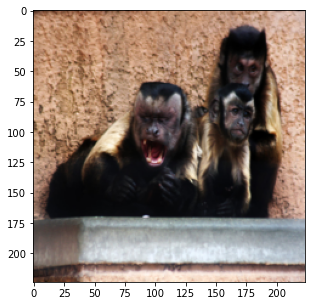

random rotate


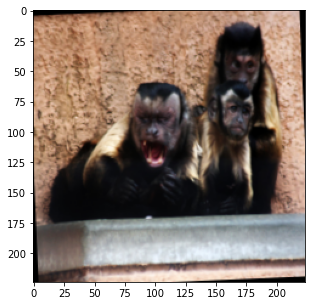

random scale


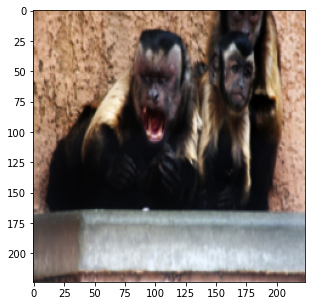

color jitter


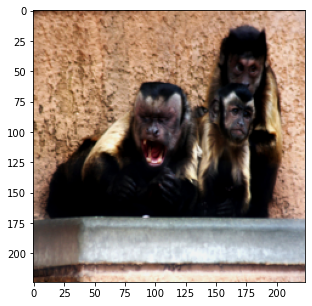

In [25]:
for trans in list(trans_list.keys()):
    print(trans)
    plot(Ten2PIL(trans_list[trans](test_x[:1]).squeeze().cpu()))

In [26]:
test_x.max(), test_x.min(), test_x.mean()

(tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'),
 tensor(0.4413, device='cuda:0'))

In [27]:
test_x.shape

torch.Size([256, 3, 224, 224])

In [28]:
torch.autograd.set_detect_anomaly(True)

tensor(12.4294, device='cuda:0')
Epoch 0 | Target Class 9 | Current Prediction 851 | Current Logits 0.000120346354378853


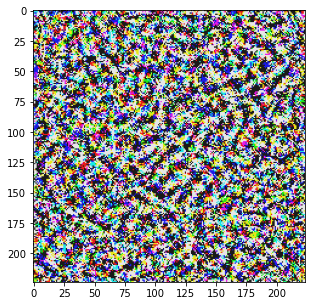

tensor(115.5647, device='cuda:0')
Epoch 500 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


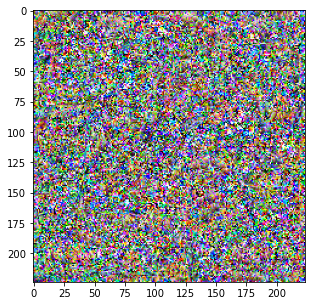

tensor(97.3786, device='cuda:0')
Epoch 1000 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


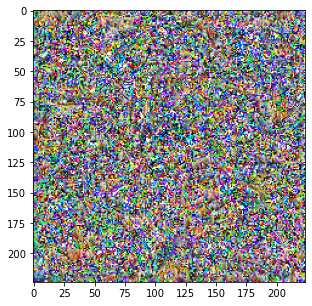

tensor(110.1063, device='cuda:0')
Epoch 1500 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


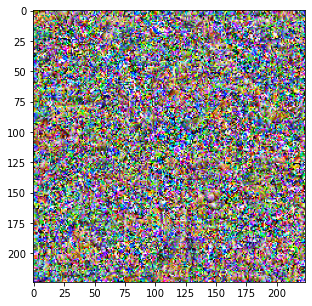

tensor(113.5602, device='cuda:0')
Epoch 2000 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


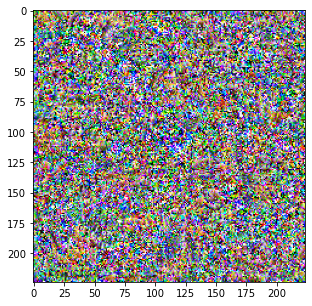

tensor(86.8928, device='cuda:0')
Epoch 2500 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


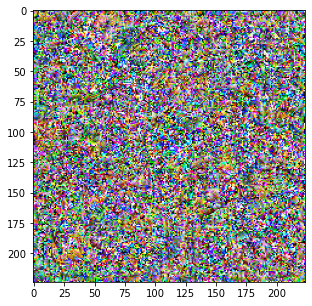

tensor(94.3258, device='cuda:0')
Epoch 3000 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


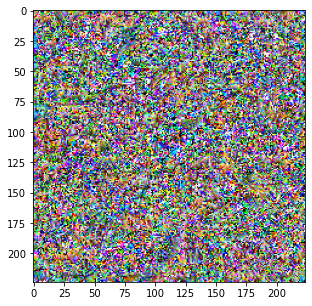

tensor(130.7411, device='cuda:0')
Epoch 3500 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


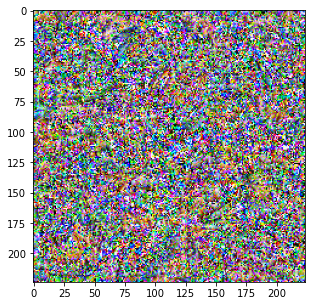

tensor(112.9464, device='cuda:0')
Epoch 4000 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


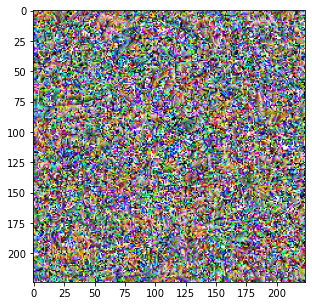

tensor(144.2073, device='cuda:0')
Epoch 4500 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


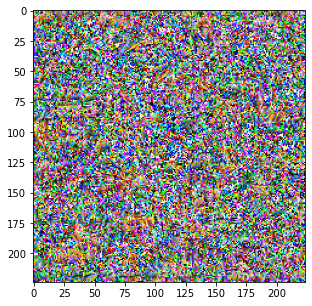

Epoch 5000 | Target Class 9 | Current Prediction 9 | Current Logits 1.0


In [43]:
for cur_class in [9]:
    for i in range(1):
        # data augmentation
        impression = torch.randint(size=(1, test_x.shape[1], test_x.shape[2], test_x.shape[3]), low=int(test_x.min()), high=int(test_x.max())).float()
        cls_impr = impression.to(device).clone().requires_grad_(True)
        # cur_impressions = [impression]
        # for trans_func in list(trans_list.keys()):
            # cur_impressions.append(PIL2Ten(trans_list[trans_func](Ten2PIL(impression.squeeze()))).unsqueeze(1))
        # cls_impr = torch.clamp(torch.stack(cur_impressions) + torch.randint(size=(28, 28), low=-10, high=10),
        #                       min=0, max=255).view(5,1,28,28).clone()
        # cls_impr.requires_grad_(True)
        
        cl_optim = torch.optim.Adam([cls_impr], lr=0.1)
        cur_pred = loaded_model(cls_impr)

        cur_tar = random.uniform(0.55, 0.99)
        cnt = 0
        while sm(cur_pred)[:, cur_class] < cur_tar or cnt < 5000: # cur_tar:
            cl_optim.zero_grad()
            cur_pred = loaded_model(cls_impr)
            # loss = cl_lossfunc(cur_pred, cur_class)
            # loss = dif_trans_lossfunc(loaded_model, cls_impr, cur_class)
            loss = karen_lossfunc(loaded_model, cls_impr, cur_class)
            loss.backward()
            cl_optim.step()
            if cnt % 500 == 0:
                print(cls_impr.grad.sum())
                print('Epoch {} | Target Class {} | Current Prediction {} | Current Logits {}'.format(
                    cnt, cur_class, cur_pred[0].argmax(-1).item(), sm(cur_pred)[0,cur_class].item()))
                plot(Ten2PIL((cls_impr.squeeze().detach().cpu())))
            cnt += 1
            with torch.no_grad():
                cls_impr.clamp_(test_x.min(), test_x.max())
    print('Epoch {} | Target Class {} | Current Prediction {} | Current Logits {}'.format(
        cnt, cur_class, cur_pred[0].argmax(-1).item(), sm(cur_pred)[0,cur_class].item()))

In [40]:
loss

tensor([27312.2402], device='cuda:0', grad_fn=<SubBackward0>)

In [41]:
cls_impr.max(), cls_impr.min()

(tensor(1., device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

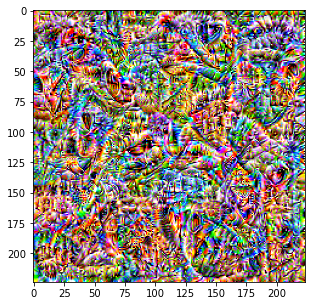

In [42]:
plot(Ten2PIL((cls_impr.squeeze().detach().cpu())))

In [37]:
with torch.no_grad():
    while True:
        test_x, test_y = next(iter(test_loader))
        if (test_y == 1).sum() > 0:
            break

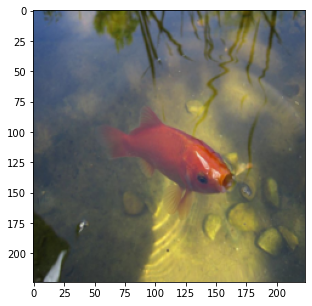

In [38]:
plot(Ten2PIL((test_x[(test_y==1).int().argmax()].squeeze().detach().cpu())))

In [20]:
# class impression in graph:
### generate cl of adjency matrix （more interested) or feature 

# assume features known, generate cl for its adjency matrix
# how to measure the similarity between two adjency matrices? (degree distribution, eigen value distribution)
# generated adjency matrix for generating UAP

# defence:
### class impressions for adversarial training 